# Next Steps:

Once this run completes, if the general form still seems to be fitting, start working on magnitude bins. Make sure to also consider that both stars and galaxies (both classified as stars) need to have a good significance when their count is multiplied by 5.

In [1]:
import sys
sys.path.insert(1, '/afs/hep.wisc.edu/home/kkboone/software/StarWeights/StellarStreams')

import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import BalrogTestConfig as balrConfig
import Config
from TrainAndFullMap import *
from timeit import default_timer as timer
matplotlib.style.use('des_dr1')

In [2]:
cutOffPercent = .01
res = 4096
binNum = 10

In [3]:
persToUse = np.logspace(0, 2, 20)

In [4]:
def mostSigInd(y):
    maxSquaredDiff = 0
    index = -1
    
    maxSingError = np.max(np.abs(y - 1))
    
    if maxSingError <= cutOffPercent:
        return index, maxSingError
    
    for i in range(len(y)):
        yi = y[i]
        
        diff = np.sum((yi - 1)**2)
        
        if diff > maxSquaredDiff:
            maxSquaredDiff = diff
            index = i
            
    return index, maxSingError

In [5]:
# allPixFile = balrConfig.test1AllPixFile
# starFile = balrConfig.test1StarFile
# validPixFile = balrConfig.test1ValidPixFile
# condFiles = balrConfig.test1CondFiles

# origCondMaps = []

# # This loops over every condition file
# for condFile in condFiles:
#     condData = fitsio.read(condFile) # This reads in the data
#     origCondMaps.append(condData['SIGNAL']) # Only stores the values that are in pixels with injections

# origCondMaps = np.array(origCondMaps) # Converts to an array

# origInjData = fitsio.read(allPixFile)

# origInjPix = hp.ang2pix(res, origInjData['RA'], origInjData['DEC'], nest = True, lonlat = True)
# origValidPix = np.unique(origInjPix)

# # Begin Comment Region
# # testSubset = np.full(len(origValidPix), False, dtype = bool)
# # testSubset[0:int(0.2*len(testSubset))] = True
# # np.random.shuffle(testSubset)
# # testPixels = origValidPix[testSubset]
# # End Comment Region

# origDetData = fitsio.read(starFile)

# origDetPix = hp.ang2pix(res, origDetData['RA'], origDetData['DEC'], nest = True, lonlat = True)

# origInjPix = np.sort(origInjPix)

# origDetPix = np.sort(origDetPix)

# # Begin Comment Region
# # injTestInds = np.isin(origInjPix, testPixels)
# # potentialInjTrainInds = ~injTestInds
# # End Comment Region

# # Everything from here until the main loop is to generate matchInds

# origInjPixUnique, origInjPixCounts = np.unique(origInjPix, return_counts = True)

# _, origAllDetPixCounts = np.unique(np.append(origDetPix, origValidPix), return_counts = True)
# origAllDetPixCounts = origAllDetPixCounts - 1

# matchInds = np.zeros(len(origDetPix), dtype = int)

# startInjInds = np.append(np.array([0]), np.cumsum(origInjPixCounts)[:-1])

# startDetInds = np.append(np.array([0]), np.cumsum(origAllDetPixCounts)[:-1])

# for i in np.arange(len(origAllDetPixCounts)):
#     if origAllDetPixCounts[i] == 0:
#         continue
#     matchInds[startDetInds[i]: startDetInds[i] + origAllDetPixCounts[i]] = np.arange(origAllDetPixCounts[i]).astype(int) + startInjInds[i]
    
# for perObjectsToUse in persToUse:
    
#     includeInds = np.full(len(origInjPix), False, dtype = bool)
#     includeInds[0:int((float(perObjectsToUse)*len(includeInds)) / 100)] = True
#     np.random.shuffle(includeInds)
    
#     # Begin Comment Region
# #     includeInds = np.full(np.sum(potentialInjTrainInds), False, dtype = bool)
# #     includeInds[0:int((float(perObjectsToUse)*len(includeInds)) / 100)] = True
# #     np.random.shuffle(includeInds)
    
# #     injTrainInds = np.copy(potentialInjTrainInds)
# #     injTrainInds[np.where(injTrainInds)[0]] = includeInds
#     # End Comment Region
    
#     detPix = origDetPix[includeInds[matchInds]]
#     injPix = origInjPix[includeInds]
    
#     # Begin Comment Region
# #     detPixTest = origDetPix[injTestInds[matchInds]]
# #     injPixTest = origInjPix[injTestInds]
    
# #     detPixTrain = origDetPix[injTrainInds[matchInds]]
# #     injPixTrain = origInjPix[injTrainInds]
    
# #     detPix = np.sort(np.append(detPixTest, detPixTrain))
# #     injPix = np.sort(np.append(injPixTest, injPixTrain))
#     # End Comment Region

#     validPix =  np.unique(injPix)
    
#     condCrop = np.isin(origValidPix, validPix)
    
#     constantTrainPixIndicator, origDetPixCounts = np.unique(np.append(validPix, detPix), return_counts = True)
#     origDetPixCounts = origDetPixCounts - 1
    
#     condMaps = []

#     # This loops over every condition file
#     for origCondMap in origCondMaps:
#         condMaps.append(origCondMap[condCrop]) # Only stores the values that are in pixels with injections

#     condMaps = np.array(condMaps)
    
#     trainInds = np.full(len(condMaps[0]), False, dtype = bool)
#     trainInds[0:int(0.8*len(trainInds))] = True
#     np.random.shuffle(trainInds)
    
#     # Begin Comment Region
#     # trainInds = np.isin(constantTrainPixIndicator, np.unique(injPixTrain))
#     # End Comment Region
    
#     # trainInds = np.isin(constantTrainPixIndicator, np.unique(injPixTrain))
    
#     aveDetTrain = np.sum(origDetPixCounts[trainInds]) / len(origDetPixCounts[trainInds])

#     sortInds = []
#     for i in range(len(condMaps)):
#         sortInds.append(condMaps[i][trainInds].argsort())
#     sortInds = np.array(sortInds)
    
#     binIndLims = [0]

#     for j in range(binNum):
#         binIndLims.append(int((np.sum(trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))
        
#     xBins = []

#     for i in range(len(condMaps)):
#         cond_Map_Sort = condMaps[i][trainInds][sortInds[i][::1]]
#         condBins = []
#         for j in range(binNum):
#             condBins.append(cond_Map_Sort[binIndLims[j]:binIndLims[j+1]])
#         indXBin = []

#         for j in range(binNum):
#             indXBin.append(np.sum(condBins[j]) / len(condBins[j]))

#         xBins.append(np.array(indXBin))

#     xBins = np.array(xBins)
    
#     yBinsOrig = []
#     for i in range(len(condMaps)):
#         detSort = origDetPixCounts[trainInds][sortInds[i][::1]]
#         detBins = []
#         for j in range(binNum):
#             detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
#         indYBinOrig = []

#         for j in range(binNum):
#             indYBinOrig.append(np.sum(detBins[j]) / (aveDetTrain * len(detBins[j])))

#         yBinsOrig.append(np.array(indYBinOrig))

#     yBinsOrig = np.array(yBinsOrig)
    
#     detPixCounts = np.copy(origDetPixCounts)
    
#     allErrors = []

#     while(True):

#         yBins = []
#         for i in range(len(condMaps)):
#             detSort = detPixCounts[trainInds][sortInds[i][::1]]
#             detBins = []
#             for j in range(binNum):
#                 detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
#             indYBin = []

#             for j in range(binNum):
#                 indYBin.append(np.sum(detBins[j]) / (aveDetTrain * len(detBins[j])))

#             yBins.append(np.array(indYBin))

#         yBins = np.array(yBins)

#         index, maxErr = mostSigInd(yBins)
#         if index == -1:
#             break

#         allErrors.append(maxErr)

#         corrFunc = inter.interp1d(xBins[index], yBins[index], bounds_error = False, fill_value = (yBins[index][0], yBins[index][-1]))

#         detPixCounts = detPixCounts / (corrFunc(condMaps[index]))

#         detPixCounts = detPixCounts * aveDetTrain / (np.sum(detPixCounts[trainInds]) / len(detPixCounts[trainInds]))
        
#     binIndLims = [0]

#     for j in range(binNum):
#         binIndLims.append(int((np.sum(~trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))
        
#     condMaxErrors = []
    
#     aveDetTest = np.sum(detPixCounts[~trainInds]) / len(detPixCounts[~trainInds])

#     for condInd in range(len(condMaps)):
#         condMap = condMaps[condInd]
#         condSortInds = condMap[~trainInds].argsort()

#         detStarTemp = detPixCounts[~trainInds][condSortInds[::1]]

#         detBins = []

#         for j in range(10):
#             detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])

#         yBinCond = []

#         for j in range(10):
#             yBinCond.append(np.sum(detBins[j]) / (aveDetTest * len(detBins[j])))

#         yBinCond = np.array(yBinCond)

#         condMaxErrors.append(np.max(np.abs(yBinCond - 1)))
        
#     condErrorsFile = balrConfig.test1Dir + 'LogConstantTest/More_Points_' + str(round(perObjectsToUse / 100, 3)) + '_Cond_Errors_' + str(cutOffPercent) + '.fits'
#     my_table = Table()
#     my_table['Errors'] = condMaxErrors
#     my_table.write(condErrorsFile, overwrite = True)
#     print(str(round(perObjectsToUse / 100, 3)) + ': ' + str(np.average(condMaxErrors)))

In [6]:
maxDevs = []
for per in persToUse:
    file = balrConfig.test1Dir + 'LogRegularAccuracy/' + str(round(per / 100, 3)) + '_Cond_Errors_' + str(0.01) + '.fits'
    maxDevs.append(fitsio.read(file)['Errors'])

In [7]:
aveMaxDev = []
for maxDev in maxDevs:
    aveMaxDev.append(np.average(maxDev))

In [8]:
import scipy as sc

In [9]:
def func(x, C, b, k):
    return C*(x**(-1*k)) + b

In [10]:
popt, pcov = sc.optimize.curve_fit(func, persToUse, aveMaxDev, bounds=([0., 0., 0], [0.1, 0.01, 2]))

In [11]:
popt

array([0.04967648, 0.00505517, 0.61442025])

In [12]:
perr = np.sqrt(np.diag(pcov))
perr

array([0.00100024, 0.00098865, 0.03669308])

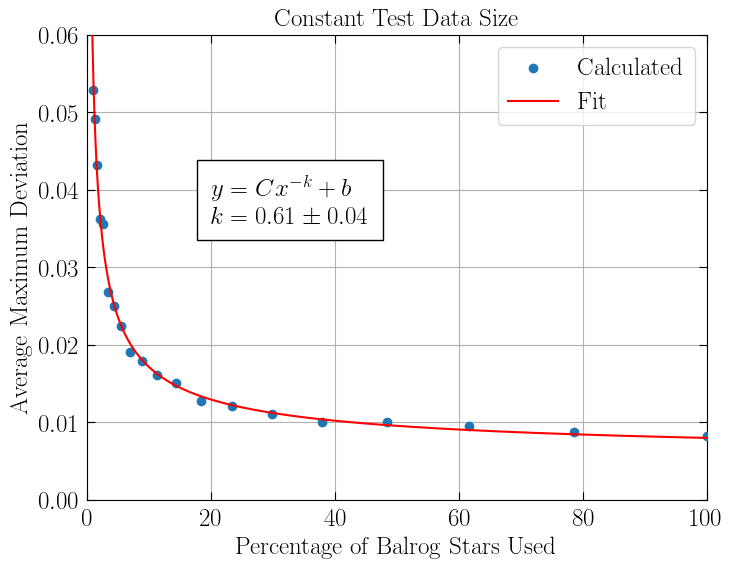

In [13]:
plt.figure()
plt.scatter(persToUse, aveMaxDev, zorder = 3, label = 'Calculated')
plt.plot(np.linspace(0.01, 100, 10000), func(np.linspace(0.01, 100, 10000), *popt), color = 'r', zorder = 3, label = 'Fit')
plt.text(20, 0.036, r'$y = Cx^{-k} + b$' '\n' r'$k = 0.61\pm 0.04$', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, zorder = 3)
plt.legend()
plt.ylim([0, 0.06])
plt.xlim([0, 100])
plt.grid(zorder = 0)
plt.ylabel('Average Maximum Deviation')
plt.xlabel('Percentage of Balrog Stars Used')
plt.title('Constant Test Data Size')
plt.show()

In [14]:
x_test = np.linspace(100, 500, 10000)

In [15]:
y_test = func(x_test, *popt)

In [16]:
if len(np.where(y_test < 0.025)[0]) == 0:
    print('Too High Precision')
else:
    print(x_test[np.where(y_test < 0.025)[0][0]])

100.0
